## Mise en place du context

In [1]:
from findspark import init
init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, lit, log, mean
from pyspark.sql.types import LongType, FloatType
from pyspark.ml.feature import VectorAssembler

Le contexte est récupéré si existant et dans l'autre cas il sera créé.

In [2]:
# Creation d'une Session Spark
spark = SparkSession.builder.getOrCreate()

## Chargement des données

In [3]:
import os.path as path
from os import makedirs

In [4]:
data_dir = "res"

In [5]:
if not path.isfile("dac.tar.gz"):
    !wget https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz

In [6]:
if not path.isdir(data_dir):
    makedirs(data_dir)

Le fichier [`dac.tar.gz`](https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz) doit se situer dans le même répertoire.

In [7]:
if not path.isfile(data_dir + "/train.txt") or not path.isfile(data_dir + "/test.txt"):
    !tar -xvzf dac.tar.gz -C $data_dir

In [5]:
# Chargement des données en data frame
df = spark.read.csv(data_dir + "/train.txt", header=False, sep="\t")

## Preparation des données

In [6]:
# Retirer toutes les valeurs nulles
df2 = df.dropna()

In [10]:
print(df.count())
print(df2.count())

45840617
756554


In [10]:
df2.schema

StructType(List(StructField(_c0,StringType,true),StructField(_c1,StringType,true),StructField(_c2,StringType,true),StructField(_c3,StringType,true),StructField(_c4,StringType,true),StructField(_c5,StringType,true),StructField(_c6,StringType,true),StructField(_c7,StringType,true),StructField(_c8,StringType,true),StructField(_c9,StringType,true),StructField(_c10,StringType,true),StructField(_c11,StringType,true),StructField(_c12,StringType,true),StructField(_c13,StringType,true),StructField(_c14,StringType,true),StructField(_c15,StringType,true),StructField(_c16,StringType,true),StructField(_c17,StringType,true),StructField(_c18,StringType,true),StructField(_c19,StringType,true),StructField(_c20,StringType,true),StructField(_c21,StringType,true),StructField(_c22,StringType,true),StructField(_c23,StringType,true),StructField(_c24,StringType,true),StructField(_c25,StringType,true),StructField(_c26,StringType,true),StructField(_c27,StringType,true),StructField(_c28,StringType,true),StructFi

Renommage des colonnes par : label, f1, f2, f3,..., f39 + Conversion des colonnes 0 à 13 inclu en float

In [7]:
def mk_newNameCol():
    res = ['label']
    for i in range(1, 14):
        res.append('I' + str(i))
    for i in range(14, 14+26):
        res.append('C' + str(i - 13))
    return res

new_name = mk_newNameCol()
print(new_name)

df3 = df2.select(*[col(c).alias(new_c) for c, new_c in zip(df2.columns, new_name)])
df4 = df3.select(*(col(c).cast("float") if i < 14 else col(c) for i, c in enumerate(df3.columns)))
df4.head(1)

['label', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26']


[Row(label=1.0, I1=0.0, I2=127.0, I3=1.0, I4=3.0, I5=1683.0, I6=19.0, I7=26.0, I8=17.0, I9=475.0, I10=0.0, I11=9.0, I12=0.0, I13=3.0, C1='05db9164', C2='8947f767', C3='11c9d79e', C4='52a787c8', C5='4cf72387', C6='fbad5c96', C7='18671b18', C8='0b153874', C9='a73ee510', C10='ceb10289', C11='77212bd7', C12='79507c6b', C13='7203f04e', C14='07d13a8f', C15='2c14c412', C16='49013ffe', C17='8efede7f', C18='bd17c3da', C19='f6a3e43b', C20='a458ea53', C21='35cd95c9', C22='ad3062eb', C23='c7dc6720', C24='3fdb382b', C25='010f6491', C26='49d68486')]

Selectionner une partie des données

In [8]:
df5 = df4.limit(1000)

In [9]:
df5.count()

10000

Convertir les features C1 à C26 en `int`

In [9]:
df6 = df5.select(*(col(c) for c in df5.columns)) # copy
fn_udf = udf(lambda x: int("0x" + x, 16))
for c in df6.columns[14:]:
    df6 = df6.withColumn(c, fn_udf(c))

In [11]:
df6.schema
df6.head(1)

[Row(label=1.0, I1=0.0, I2=127.0, I3=1.0, I4=3.0, I5=1683.0, I6=19.0, I7=26.0, I8=17.0, I9=475.0, I10=0.0, I11=9.0, I12=0.0, I13=3.0, C1='98275684', C2='2303194983', C3='298440606', C4='1386710984', C5='1291264903', C6='4222442646', C7='409410328', C8='185940084', C9='2805916944', C10='3467707017', C11='1998662615', C12='2035317867', C13='1912860750', C14='131152527', C15='739558418', C16='1224818686', C17='2399067775', C18='3172451290', C19='4137935931', C20='2757290579', C21='902665673', C22='2905629419', C23='3353110304', C24='1071331371', C25='17786001', C26='1238795398')]

In [10]:
df7 = df6.select(*(col(c) for c in df6.columns)) # copy
for c in df7.columns[14:]:
    df7 = df7.withColumn(c, df7[c].cast(LongType()))

In [23]:
df7.head(1)

[Row(label=1.0, I1=0.0, I2=127.0, I3=1.0, I4=3.0, I5=1683.0, I6=19.0, I7=26.0, I8=17.0, I9=475.0, I10=0.0, I11=9.0, I12=0.0, I13=3.0, C1=98275684, C2=2303194983, C3=298440606, C4=1386710984, C5=1291264903, C6=4222442646, C7=409410328, C8=185940084, C9=2805916944, C10=3467707017, C11=1998662615, C12=2035317867, C13=1912860750, C14=131152527, C15=739558418, C16=1224818686, C17=2399067775, C18=3172451290, C19=4137935931, C20=2757290579, C21=902665673, C22=2905629419, C23=3353110304, C24=1071331371, C25=17786001, C26=1238795398)]

In [11]:
assembler = VectorAssembler(
    inputCols=df7.columns[1:],
    outputCol="features")

In [12]:
data = assembler.transform(df7).select(col("label"), col("features"))

In [13]:
data.schema

StructType(List(StructField(label,FloatType,true),StructField(features,VectorUDT,true)))

## Apprentissage

In [13]:
seed = 54548421

In [14]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [15]:
# Split des données en 60% train 40% validation
# Pensez à changer la ligne "data.randomSplit(...)" par "df7.randomSplit(...)" si vous souhaitez éxecuter le pipeline avec
# Random Forest plus bas dans la page.
tmp = data.randomSplit([0.6, 0.4], seed)
train = tmp[0]
test = tmp[1]

In [16]:
# Définition de la fonction qui calcul la log_loss afin de représenter au mieux la métric de Kaggle
def compute_log_loss(raw_prediction_labels):
    get_item_udf = udf(lambda v: float(v[1]), FloatType())
    tmp = raw_prediction_labels.withColumn("proba", get_item_udf(col("probability")).cast("float"))
    res = tmp.withColumn("ll", - col("label").cast("float") * log(col("proba")) - (1 - col("label").cast("float")) * log(1 - col("proba")))
    return res.select(mean(col("ll"))).collect()

### Classifier : MLP

In [17]:
trainer = MultilayerPerceptronClassifier(maxIter=10, layers=[39, 2], blockSize=128, seed=seed)

In [19]:
model = trainer.fit(train)

In [20]:
res = model.transform(test)
pred_lbl = res.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(pred_lbl)))

Test set accuracy = 0.533678756476684


### Classifier : Regression Logistic

In [21]:
trainer2 = LogisticRegression()

In [22]:
model_logReg = trainer2.fit(train)

In [23]:
resReg = model_logReg.transform(test)
pred_lbl = resReg.select("prediction", "label")
evaluator2 = MulticlassClassificationEvaluator(metricName = "accuracy")
print("Test set accuracy = ", evaluator2.evaluate(pred_lbl))

Test set accuracy =  0.6839378238341969


### Implementation with Pipeline (VectorAssembler + classifier : Random Forest)

In [15]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [16]:
# Pour que l'execution de cette case fonctionne il faut executer le split des donnée avant. Evidemment sans executer le
# premier "VectorAssembler" situé légèremement au dessus.
assembler = VectorAssembler(
    inputCols=df7.columns[1:],
    outputCol="features")

trainer3 = RandomForestClassifier()

pipeline = Pipeline(stages = [assembler, trainer3])

In [17]:
rndF_fitted = pipeline.fit(train)

In [18]:
resRnd = rndF_fitted.transform(test)
pred_lbl = resRnd.select("prediction", "label")
evaluator3 = MulticlassClassificationEvaluator(metricName = "accuracy")
print("Test set accuracy = ", evaluator3.evaluate(pred_lbl))

Test set accuracy =  0.7305699481865285


In [19]:
ll = compute_log_loss(resRnd)
print("log loss  = ", ll) # Le résultat produit par cette éxecution est donc le plus représentatif vis à vis de ce projet.

log loss  =  [Row(avg(ll)=0.5569349632388336)]


In [23]:
resRnd2 = rndF_fitted.transform(test)
pred_lbl2 = resRnd2.select("rawPrediction", "prediction", "label")
evaluator3_1 = BinaryClassificationEvaluator()
print("Test set ROC = ", evaluator3_1.evaluate(pred_lbl2)) # Area under the Curve

Test set ROC =  0.7080550139817537


### Plot of ROC Curve on testing set

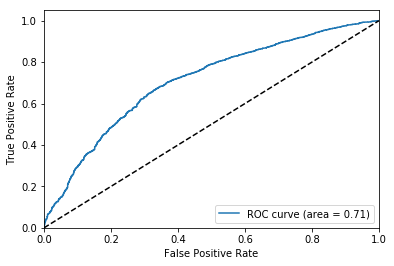

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

results = resRnd2.select(['probability', 'label'])

results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()